In [119]:
import torch
import numpy as np
import pandas as pd
import yfinance as yf
from pathlib import Path
from math import sqrt
from xgboost import XGBRegressor
from chronos import Chronos2Pipeline

In [120]:
# --- 1) SETTINGS ---
SYMBOL = "TSLA"  # Change to BTC-USD, NVDA, etc. to test generalization
VIX_SYMBOL = "^VIX"
INTERVAL = "1wk"
PERIOD ='5y'
MODEL_ID = "amazon/chronos-2"
TEST_SIZE = 30
MIN_CONTEXT = 64
REDUCED_LOOKBACK = 5  # Reduced to 5 to minimize noise and improve generalization
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

XGB_PARAMS = dict(
    n_estimators=500,
    learning_rate=0.02,
    max_depth=3,         # Shallower trees to prevent overfitting on small residuals
    booster='dart',
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
)

In [121]:
# --- 2) DATA LOADING (Asset + Global Macro Sentiment) ---
print(f"Fetching {SYMBOL} and {VIX_SYMBOL} data...")

def load_standardized_data(symbol):
    # Use multi_level_index=False to keep columns flat
    data = yf.download(symbol, period="5y", interval=INTERVAL, auto_adjust=True, multi_level_index=False, progress=False)
    data = data.reset_index()
    data.columns = [str(c).lower() for c in data.columns]

    
    # Standardize time column
    data = data.rename(columns={'date': 'timestamp'})
    data["timestamp"] = pd.to_datetime(data["timestamp"]).dt.tz_localize(None)
    
    return data

df = load_standardized_data(SYMBOL)
vix_df = load_standardized_data(VIX_SYMBOL)


prices = df.set_index("timestamp")["close"].astype(float).dropna()



Fetching TSLA and ^VIX data...


In [122]:
# --- 3) FEATURE ENGINEERING (RSI + Technicals + Seasonality) ---
def add_technicals(df):

    close = df['close'].squeeze()
    high = df['high'].squeeze()
    low = df['low'].squeeze()
    vol=df['volume'].squeeze()

    # 1. Price Rate of Change (ROC) - 4 weeks
    df['roc'] = ((close - close.shift(4)) / close.shift(4)) * 100

    # 2. On-Balance Volume (OBV)
    df['obv'] = (np.sign(close.diff()) * vol).fillna(0).cumsum()

    # 3. Williams %R (14-week)
    high_14 = high.rolling(14).max()
    low_14 = low.rolling(14).min()
    df['williams_r'] = ((high_14 - close) / (high_14 - low_14)) * -100

    # 4. Stochastic Oscillator (14-week)
    df['stoch_k'] = ((close - low_14) / (high_14 - low_14)) * 100
    df['stoch_d'] = df['stoch_k'].rolling(3).mean()


    # RSI (Relative Strength Index)
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / (loss + 1e-9)
    df['rsi'] = 100 - (100 / (1 + rs))

    # MACD (Trend/Momentum)
    ema12 = df['close'].ewm(span=12, adjust=False).mean()
    ema26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema12 - ema26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    
    # Bollinger Bands (Volatility/Mean Reversion)
    sma20 = df['close'].rolling(window=20).mean()
    std20 = df['close'].rolling(window=20).std()
    df['bb_upper'] = sma20 + (std20 * 2)
    df['bb_lower'] = sma20 - (std20 * 2)
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / sma20
    
    # ATR (Volatility)
    high_low = df['high'] - df['low']
    high_cp = np.abs(df['high'] - df['close'].shift())
    low_cp = np.abs(df['low'] - df['close'].shift())
    df['atr'] = pd.concat([high_low, high_cp, low_cp], axis=1).max(axis=1).rolling(14).mean()
    
    # Seasonality (Cyclic Month)
    df['month_sin'] = np.sin(2 * np.pi * df['timestamp'].dt.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['timestamp'].dt.month / 12)

    # Trend Divergence (Is price too far from the average?)
    df['ema_20'] = close.ewm(span=20).mean()
    df['dist_ema'] = (close - df['ema_20']) / df['ema_20']
    
    return df

df = add_technicals(df)

In [123]:
# Align VIX and combine
vix = vix_df.set_index("timestamp")["close"].rename('vix')
feat = df.set_index("timestamp").join(vix).ffill()
feat["vix"] = vix

# Shift features to prevent leakage
# We use 'rsi' and others from the PREVIOUS week to predict the NEXT close
indicator_cols = ['rsi','macd','macd_signal','bb_width',
                  'atr','vix','month_sin','month_cos'
                  ]
for col in indicator_cols:
    feat[col] = feat[col].shift(1)

# Return Lags
for i in range(1, REDUCED_LOOKBACK + 1):
    feat[f"ret_lag_{i}"] = feat["close"].pct_change().shift(i)

feat["y_true"] = feat["close"].shift(-1)
feat = feat.dropna()

In [124]:
# --- 4) CHRONOS PREDICTION (Price-Only Baseline) ---
print(f"Loading {MODEL_ID} on {DEVICE}...")
pipeline = Chronos2Pipeline.from_pretrained(MODEL_ID, device_map=DEVICE, torch_dtype=torch.float32)

def chronos_predict_1step_q50(train_series):
    input_df = pd.DataFrame({
        "item_id": ["ASSET"] * len(train_series),
        "timestamp": train_series.index,
        "target": train_series.values.flatten(),
    })
    forecast_df = pipeline.predict_df(input_df, prediction_length=1, quantile_levels=[0.5])
    return float(forecast_df.iloc[0]["0.5"])

Loading amazon/chronos-2 on cpu...


In [125]:
# --- 5) GENERATE CHRONOS OOS FEATURES ---
# Use expanding window to get what Chronos would have guessed at each point
print("Generating Chronos Out-of-Sample features...")
chronos_results = {}
for i in range(len(prices)):
    train = prices.iloc[:i]
    if len(train) < MIN_CONTEXT: continue
    ts = prices.index[i]
    chronos_results[ts] = chronos_predict_1step_q50(train)
chronos_q50 = pd.Series(chronos_results, name="chronos_q50")

Generating Chronos Out-of-Sample features...


In [126]:
# --- 6) FINAL MODELING DATAFRAME ---
model_df = feat.copy()
model_df["chronos_q50"] = chronos_q50
model_df = model_df.dropna(subset=["chronos_q50", "y_true"]).copy()

feature_cols = indicator_cols + [c for c in model_df.columns if "lag" in c] + ["chronos_q50"]

In [127]:
feature_cols

['rsi',
 'macd',
 'macd_signal',
 'bb_width',
 'atr',
 'vix',
 'month_sin',
 'month_cos',
 'ret_lag_1',
 'ret_lag_2',
 'ret_lag_3',
 'ret_lag_4',
 'ret_lag_5',
 'chronos_q50']

In [128]:
# --- 7) WALK-FORWARD BACKTEST (Residual Learning) ---
def walk_forward_residual_ensemble(df, features, target_col, test_size):
    preds = []
    importances = []
    split_idx = len(df) - test_size
    
    print(f"Starting Walk-Forward Residual Backtest ({test_size} windows)...")
    for i in range(split_idx, len(df)):
        train = df.iloc[:i]
        test_row = df.iloc[i:i+1]
        
        # Calculate the Residual (Error) of Chronos for the training set
        y_train_residual = train[target_col] - train["chronos_q50"]
        
        # Train XGBoost to predict the ERROR, not the price
        model = XGBRegressor(**XGB_PARAMS)
        model.fit(train[features], y_train_residual)

        # store importance from the latest window
        importances.append(model.feature_importances_)
        
        # Predict the correction for the test step
        ts = test_row.index[0]
        chronos_base = test_row["chronos_q50"].iloc[0]
        predicted_error = model.predict(test_row[features])[0]
        
        # Final Prediction = Chronos Global Signal + XGBoost Local Correction
        y_pred_final = chronos_base + predicted_error
        
        preds.append({
            "timestamp": ts,
            "y_true": float(test_row[target_col].iloc[0]),
            "y_pred": y_pred_final
        })
        
    return pd.DataFrame(preds), np.mean(importances, axis=0)

# Execute Ensemble
pred_ens, mean_importance = walk_forward_residual_ensemble(model_df, feature_cols, "y_true", TEST_SIZE)

Starting Walk-Forward Residual Backtest (30 windows)...


In [129]:
# --- 8) METRICS ---
import matplotlib.pyplot as plt

mae = np.mean(np.abs(pred_ens["y_true"] - pred_ens["y_pred"]))
rmse = np.sqrt(np.mean((pred_ens["y_true"] - pred_ens["y_pred"]) ** 2))
mape = np.mean(np.abs((pred_ens["y_true"] - pred_ens["y_pred"]) / pred_ens["y_true"])) * 100

print(f"\nFinal Ensemble Metrics:")
print(f"  MAE:  {mae:,.2f}")
print(f"  RMSE: {rmse:,.2f}")
print(f"  MAPE: {mape:.2f}%")


Final Ensemble Metrics:
  MAE:  24.90
  RMSE: 33.06
  MAPE: 6.01%


In [130]:
importance_df = pd.DataFrame(
    {'feature': feature_cols,
     'importance': mean_importance}
).sort_values('importance', ascending=True)

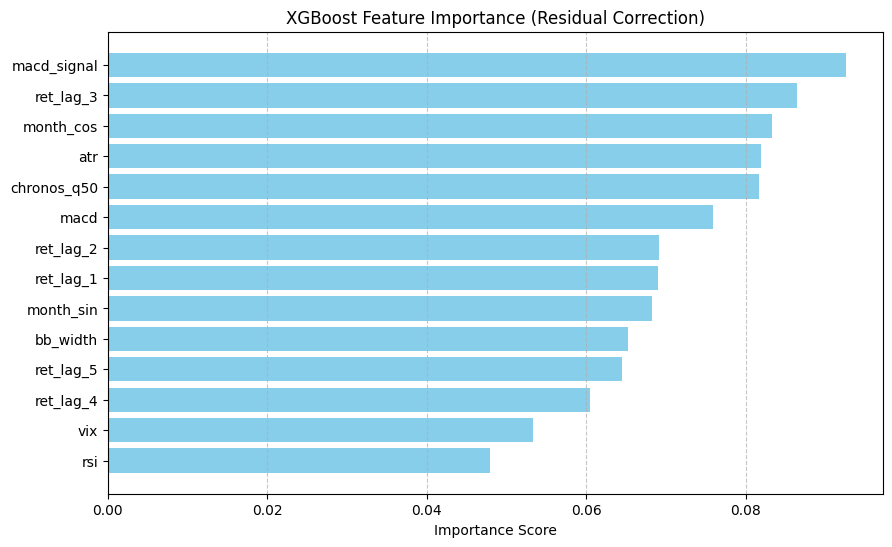

In [131]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.title("XGBoost Feature Importance (Residual Correction)")
plt.xlabel("Importance Score")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

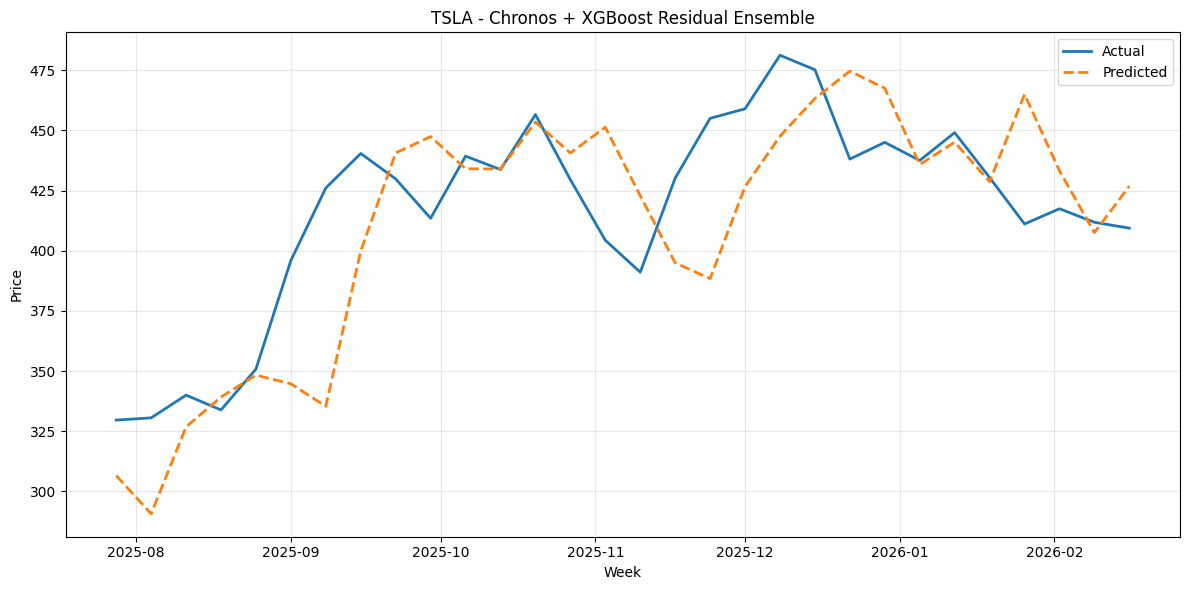

In [132]:
# Visualization
plt.figure(figsize=(12, 6))
plt.plot(pred_ens['timestamp'],pred_ens["y_true"].values, label="Actual", linewidth=2)
plt.plot(pred_ens['timestamp'],pred_ens["y_pred"].values, label="Predicted", linewidth=2, ls='--')
plt.xlabel("Week")
plt.ylabel("Price")
plt.title(f"{SYMBOL} - Chronos + XGBoost Residual Ensemble")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [133]:
# Save Artifact
# REPO_ROOT = Path.cwd().parent.parent
# ART = REPO_ROOT / "model" / "notebooks" / "artifacts"
# ART.mkdir(parents=True, exist_ok=True)
# pred_ens.to_parquet(ART / "pred_chronos_xgb_weekly_price.parquet", index=False)
# print(f"Saved to {ART}/pred_chronos_xgb_weekly_price.parquet")